# Upload data

In [ ]:
#import sys
#!{sys.executable} -m pip install dash

In [2]:
import pandas as pd
import os #for viewing HTML in web browser
import matplotlib.pyplot as plt
from typing import Tuple, List # If you have functions that return more than one value, 
# they will be returned in a tuple and you need this  to write that out in typehints

In [4]:
# Display Pandas dataframes such that they're easy to scroll through
from IPython.display import display, HTML
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns

In [6]:
#Open df in the browser - easiest way to view all the data in this large dataset
def to_html(df: pd.DataFrame) -> str:
    '''
    Render the df in HTML. Return the full HTML address. You can paste the HTML address in the 
    address bar to see the df at any time.
    '''
    df.to_html('df_view.html')
    full_path = os.path.abspath('df_view.html')
    print(full_path)

In [8]:
#Load file
# work_filepath = "C:\\Users\\kylimcqueen\\Downloads\\all_nts_animals_baseline_tall_00.csv"
#mac_filepath = '/Users/kyli/Desktop/Neurotrauma/all_nts_animals_baseline_tall_00.csv'
filepath=("C:\\Users\\kylimcqueen\\Downloads\\all_nts_animals_baseline_tall_00.csv")

In [10]:
#Check that we grabbed the filepath
print(filepath)

C:\Users\kylimcqueen\Downloads\all_nts_animals_baseline_tall_00.csv


In [12]:
#Create df
original_df = pd.read_csv(filepath)

In [14]:
#Look at the df
to_html(original_df)

C:\Git\Sleep-Analysis\df_view.html


In [16]:
# Get the shape of the datast
original_df.shape

(19584, 12)

# Data Cleaning

## Remove excluded animals

We are only using data from animals in the sham vehicle and injured vehicle groups.

In [20]:
#Check for excluded animals
def whats_in_the_col(df: pd.DataFrame, data_name: str, col_name: str) -> Tuple[int, List[str]]:
    '''
    Counts the number of cells in the specified column of the dataframe that don't 
    exactly match the string "Included".
    '''
    assert len(df[col_name]) == len(df) #Assert we're accessing the whole column

    #Assert all values in the column are of the same type (string)
    #.map(type) gets the type of each value
    #.nunique() counts number of unique types
    assert df[col_name].map(type).nunique() == 1, "Not all values are the same type"
                            
    # Get values that don't match the data_name
    non_matching_mask: list = df[col_name] != data_name
    
    # Count how many cells don't match
    count: int = non_matching_mask.sum()
    
    # Get the actual values that don't match
    non_matching_values: list = df.loc[non_matching_mask, col_name].unique().tolist()
    
    return count, non_matching_values

DON'T NEED TO RUN THE CELLS BELOW FOR BASELINE, WE ALREADY KNOW THERE ARE EXCLUDED ANIMALS IN THAT DATASHEET

In [ ]:
count, no_match_list = whats_in_the_col(original_df, "Included", "Included")

In [ ]:
# Check that this Excel file only has animals that are included in the study (animals that lived past injury)

print(f' Count: {count}.\nIf count = 0 then every item in the column matches the data_name, which, for NTS sleep files, is "Included".\n\n') 
print(f' List of values that don\'t match the target value: {no_match_list}\nIf no_match_list is empty, then every item in the column matches the data name, which, for the postinjury file, is "Included".') 
print(f'\n\nFor baseline it\'s fine to keep excluded animals because it\'s good to have more data than less data.')

## Remove animals given drug

DON'T RUN THE CELL BELOW FOR BASELINE

In [ ]:
# Check how many animals are not vehicle - don't run for baseline for now
count, no_match_list = whats_in_the_col(original_df, "vehicle", "Treatment")
print(f" There are {count} cells in this column that don't match the string that you searched for")

'''
Interesting, when I run the baseline file I get an error that says "Not all values are the same type, which suggests that maybe in the
baseline file the Treatment column has strings and floats but in the postinjury file all the values are strings, including the numbers?
Not sure, let's just not run this cell for baseline.
'''

In [22]:
# Filter the dataframe to remove animals that were treated with drug
vehicle_df = original_df.loc[original_df['Treatment'] == 'vehicle']

In [24]:
print(f"Original dataframe shape: {original_df.shape}")
print(f"Filtered dataframe shape: {vehicle_df.shape}")
print(f"Unique treatment values in filtered dataframe: {vehicle_df['Treatment'].unique()}")

Original dataframe shape: (19584, 12)
Filtered dataframe shape: (5355, 12)
Unique treatment values in filtered dataframe: ['vehicle']


In [26]:
# If you want to see the list of unique animals
unique_animals = vehicle_df['UniqueMouse'].unique()
print(f"There are {len(unique_animals)} unique animals in the dataset.\nList of unique animals: {unique_animals}")


There are 35 unique animals in the dataset.
List of unique animals: ['C1-01' 'C1-07' 'C1-14' 'C2-04' 'C2-05' 'C2-09' 'C2-13' 'C3-04' 'C3-07'
 'C3-10' 'C3-14' 'C4-01' 'C4-04' 'C4-06' 'C4-10' 'C4-15' 'C5-03' 'C5-11'
 'C5-14' 'C5-15' 'C6-02' 'C6-04' 'C6-06' 'C6-09' 'C6-11' 'C6-15' 'C7-02'
 'C7-07' 'C7-14' 'C7-15' 'C8-05' 'C8-06' 'C8-12' 'C8-13' 'C8-16']


## Handle leading and lagging NaN values

Data is in [TIDY](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html) format. This means each row is an observation and each column is a variable. For each different cohort, there is a certain number of NaNs at the beginning and end of sleep percent column. This is because of the way the data was originally formatted in the Excel. To address missing values, we need to get rid of all the leading and lagging NaNs and keep in mind that the number of leading and lagging Nans is the same within each cohort but different between each cohort.

Note: There are 71 animals in the postinjury dataset (excluding cohort 8).

Note: All UniqueMice should have 372 rows of data before trimming the leading and lagging NaNs. 372 rows per UniqueMouse * 71 UniqueMice = 26412 total rows of data, which is in agreement with the shape of the original postinjury df. Every UniqueMouse has between 300 and 400 data points and the number of datapoints is consistent within each Cohort.

In [29]:
def trim_nan_edges(df: pd.DataFrame, cohort_col: pd.Series, mouse_col: pd.Series, data_col:pd.Series):
    '''
    Get rid of the leading and lagging NaNs at the beginning and end of the set of rows that represent 
    all observations for each mouse. Do not get rid of NaNs in the middle of observations. 
    All mice within the same cohort have the same number of leading and lagging NaNs.
    '''
    trimmed_groups: list = []

    # Nested for loop to loop over each UniqueMouse within each Cohort
    df_grouped = df.groupby(cohort_col) # Group by Cohorts
    for cohort_name, cohort_group in df_grouped: # Loop over each cohort    
        for mouse_name, mouse_group in cohort_group.groupby(mouse_col): # Loop over UniqueMouse
    
            mouse_group = mouse_group.reset_index(drop=True) # Reset the index for the rows of a UniqueMouse
            #print(f' The length of the mouse group is {len(mouse_group)}. The length of the mouse group should be 514 for postinjury.') testing
            # Create a new list called valid_mask where each entry is a boolean value where T = 1 = a number and
            # F = 0 = a NaN for that Uniquemouse's SleepPercent data
            valid_mask = mouse_group[data_col].notna() 

            #If there are any NaNs
            if valid_mask.any():
                # first_valid_idx is the first index that returns true - the first number after leading NaNs
                first_valid_idx = valid_mask.idxmax()
                # last_valid_idx is the first index going backwards that returns true - the last number before lagging NaNs
                last_valid_idx = valid_mask[valid_mask].index[-1]
                #print(f' The number of rows in this list is {len(valid_mask)}') # Testing statement
    

                # Take the first_valid_idx and last_valid_idx, match them to corresponding actual values in the UniqueMouse
                # SleepPercent data, and put the actual SleepPercent values in a new list called trimmed
                trimmed = mouse_group.iloc[first_valid_idx:last_valid_idx + 1].copy() 
                #print(len(trimmed)) #Testing statement
                # Add the trimmed SleepPercent column from one UniqueMouse to the trimmed_groups list, which is a list
                # of trimmed values for all UniqueMice across all Cohorts
                trimmed_groups.append(trimmed) # Add the trimmed SleepPercent column to the 
    
    trimmed_df = pd.concat(trimmed_groups, ignore_index=True)
    return trimmed_df

In [31]:
# Run trim_nan_edges function
trimmed_df = trim_nan_edges(vehicle_df, "Cohort", "UniqueMouse", "PercentSleep")

In [33]:
to_html(trimmed_df)

C:\Git\Sleep-Analysis\df_view.html


## Remove unnecessary columns

There are multiple ways to do this. You can mask, like df[['Column name', 'Next column name', 'etc']]. 
You can use .loc to select specific parts of the df.

Using .loc is likely the more stable way because when you mask it creates a something like a temporary DataFrame whose relationship to the original dataframe is unclear using a chained indexing operation. This means its not always clear whether the dataframe returned by masking is a view of the original dataframe or a copy of it. Therefore, when you try to further modify a mask of the dataframe, Pandas isn't always sure whether to modify the original or the view/copy. So you sometimes get SettingWithCopyWarnings.

Using df.loc[:,columns] grabs all the rows from whatever columns you're interested in preserving. It's a single indexing operation that returns a view of the original dataframe. When you make changes with .loc, they will affect the original DataFrame.

In [37]:
trimmed_df.columns

Index(['StudyPart', 'UniqueMouse', 'Cohort', 'InjuredGroup', 'Treatment',
       'Included', 'Lights', 'HourOfDay', 'CumulativeHour', 'DoseMarker',
       'PercentSleep', 'SleepBout'],
      dtype='object')

In [39]:
# Identify the relevant columns for later analysis
relevant_cols = ['UniqueMouse', 'Cohort', 'InjuredGroup', 'Treatment','HourOfDay', 'CumulativeHour', 'PercentSleep']

In [41]:
# Remove unnecessary columns
no_nan_df = trimmed_df.loc[:,relevant_cols]
no_nan_df

,UniqueMouse,Cohort,InjuredGroup,Treatment,HourOfDay,CumulativeHour,PercentSleep
0,C1-01,C1,Sham,vehicle,10,11,57.17
1,C1-01,C1,Sham,vehicle,11,12,66.28
2,C1-01,C1,Sham,vehicle,12,13,16.67
3,C1-01,C1,Sham,vehicle,13,14,79.44
4,C1-01,C1,Sham,vehicle,14,15,53.94
5,C1-01,C1,Sham,vehicle,15,16,60.67
6,C1-01,C1,Sham,vehicle,16,17,93.61
7,C1-01,C1,Sham,vehicle,17,18,45.67
8,C1-01,C1,Sham,vehicle,18,19,39.06
9,C1-01,C1,Sham,vehicle,19,20,40.00


## Remove duplicates

In [44]:
duplicate_count = no_nan_df.duplicated().sum()
print(f' Number of duplicate rows: {duplicate_count}')

 Number of duplicate rows: 0


## Check and convert datatypes

### Change object datatypes to categories

In [48]:
print(f'DataFrame information: \n{no_nan_df.info()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3669 entries, 0 to 3668
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   UniqueMouse     3669 non-null   object 
 1   Cohort          3669 non-null   object 
 2   InjuredGroup    3669 non-null   object 
 3   Treatment       3669 non-null   object 
 4   HourOfDay       3669 non-null   int64  
 5   CumulativeHour  3669 non-null   int64  
 6   PercentSleep    3663 non-null   float64
dtypes: float64(1), int64(2), object(4)
memory usage: 200.8+ KB
DataFrame information: 
None


In [50]:
'''Convert columns with type 'object' to categories because all data in these columns are limited unique values that repeat (like group identifiers).
Category designation stores data as categorical/enumerated values, is more memory-efficient, and is faster for operations on columns.'''
def turn_obj_cols_to_categories(df: pd.DataFrame) -> pd.DataFrame:
    obj_cols = df.select_dtypes(include='object').columns
    for col in obj_cols:
        df[col] = df[col].astype('category')
    return df

In [ ]:
turn_obj_cols_to_categories(no_nan_df)

In [54]:
no_nan_df.dtypes

UniqueMouse       category
Cohort            category
InjuredGroup      category
Treatment         category
HourOfDay            int64
CumulativeHour       int64
PercentSleep       float64
dtype: object

# Handle all other NaNs - will do this after exploraratory data analysis

In [ ]:
# See the % of NaNs per total data for each UniqueMouse
na_summary = no_nan_df["PercentSleep"].isna().groupby(no_nan_df["UniqueMouse"]).mean()
# Print the % NaNs per total data for each UniqueMouse from largest to smallest
print(f' There are a total of {len(na_summary)} mice.')
print(type(na_summary.sort_values(ascending=False)))
print(na_summary.sort_values(ascending=False))

'''
Postinjury: The vast majority of animals with NaN values are from Cohort 5. 
Baseline: It apperas that the only NaN values are that one row of NaNs in cohort 6 - it just means that all animals 
in cohort 6 are missing one hour of data.
'''

### How do we fill NaNs?

Options: 

a. Drop them. This is likely to break analysis.
df = df.dropna(subset=['PercentSleep'])

b. Forward fill or backward fill because sleep is continuous and doesn't change abruptly.
df['PercentSleep'] = df.groupby('UniqueMouse')['PercentSleep'].ffill().bfill() (I think choose either ffill or bfill)

c. Interpolate. This is a good process to use for evenly spaced time series (ex: hourly data) because it creates a straight line between
two adjacent data points and estimates the value between them. It considers the lienar relationshp between the known data points (Medium article)[https://medium.com/@datasciencewizards/preprocessing-and-data-exploration-for-time-series-handling-missing-values-e5c507f6c71c]
df["PercentSleep"] = df.groupby("UniqueMouse")["PercentSleep"].transform(lambda x: x.interpolate())

d. Flag and leave. Can make a new column to flag for missingness and ealuate that later?

Note: In the baseline combined datasheet I see that there is one hour where all cohort 6 animals have NaNs

In [ ]:
# Interpolation
no_nan_df["PercentSleep"] = no_nan_df.groupby("UniqueMouse", observed=False)["PercentSleep"].transform(lambda x: x.interpolate())

In [ ]:
# Check that there's no NaNs now
na_summary = no_nan_df["PercentSleep"].isna().groupby(no_nan_df["UniqueMouse"]).mean()
print(f' There are a total of {len(na_summary)} mice.')
print(type(na_summary.sort_values(ascending=False)))
#print(na_summary.sort_values(ascending=False))

#Maybe replace this with an assert statement


# Remove outliers

## Visually determined outliers

This step occurs after visualization, because visualization helps you determine the outliers. However, I am putting it before visualization in the notebook so that after discovering issues, when the user subsequently runs all code cells, the appropriate data can be dropped as necessary before visualization.

ONLY RUN THE CELL BELOW FOR POSTINJURY

In [ ]:
# Remove the three animals from cohort 5 animals because they are missing 25 hours of data.
# The new df no_nan_df is equal to the old no_nan_df where we grouped by Cohort and took all the data where 'Cohort' is not equal to 5
clean_df = no_nan_df.loc[no_nan_df['Cohort'] != 'C5']

# Check that 5 has been removed with assert statement
assert (clean_df['Cohort'] != 'C5').all(), "Cohort 5 still present in data!"

ONLY RUN THE CELL BELOW FOR BASELINE

In [56]:
# Note that I need to change the names of these dfs because they're not matching up with what's actually happening
# This cell is only for baseline because we don't need to get rid of Cohort 5 for baseline
clean_df = no_nan_df

# Save dataframe

Take a moment to save the final, cleaned dataframe for further analyses in other notebooks.

In [102]:
clean_df.to_csv('baseline_clean_df_04142025.csv', index=False)

In [58]:
# Make a dictionary of dataframes so that you can view each cohort independently
# Each key is the name of the cohort (ex: C2, C3, etc) and the value is the datafarme of that cohort only
cohorts_dict = {cohort: data for cohort, data in clean_df.groupby('Cohort')}

C:\Users\kylimcqueen\AppData\Local\Temp\ipykernel_22368\499499547.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cohorts_dict = {cohort: data for cohort, data in clean_df.groupby('Cohort')}


In [60]:
# Look at the keys to make sure all desired cohorts are there 
print(cohorts_dict.keys())

dict_keys(['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8'])


In [32]:
#cohorts_dict['C5']

# Data size

In [62]:
# Number of unique animals after data cleaning
unique_animals = no_nan_df['UniqueMouse'].nunique()
print(f'There are {unique_animals} unique animals in the dataset after initial data cleaning')

There are 35 unique animals in the dataset after initial data cleaning


# Visualization

In [ ]:
clean_df['UniqueMouse'].unique().tolist()

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

In [36]:

mouse_palette = {'C1-01': '#f3beb3',
                 'C1-07': '#f0785f',
                 'C1-14': '#d06c58',
                 
                 'C2-04': '#e2f0cd',
                 'C2-05': '#afdc6b',
                 'C2-09': '#6ca419',
                 'C2-13': '#43831e',
                 
                 'C3-04': '#b7e8e8',
                 'C3-07': '#549e9e',
                 'C3-10': '#32e7e7',
                 'C3-14': '#0e7878',
                 
                 'C4-01': '#90c8e7',
                 'C4-04': '#41a2d8',
                 'C4-06': '#b1b7b9',
                 'C4-10': '#3b474b',
                 'C4-15': '#066281',

                 'C5-11': '#8e8685',
                 'C5-15': '#5f514f',
                 'C5-14': '#090706',
                 'C5-03': '#873811',
                 
                 'C6-02': '#a8b6ec',
                 'C6-04': '#7380b2',
                 'C6-06': '#3355da',
                 'C6-09': '#0c299b',
                 'C6-11': '#bcbfca',
                 'C6-15': '#051550',
                 
                 'C7-02': '#eed3f0',
                 'C7-07': '#ee82f6',
                 'C7-14': '#b515c1',
                 'C7-15': '#5e1764',
                 
                 'C8-05': '#FFA07A',
                 'C8-06': '#E9967A',
                 'C8-12': '#FA8072',
                 'C8-13': '#F08080',
                 'C8-16': '#CD5C5C'
                }


In [ ]:
# Create a plot for percent sleep per hour for each cohort

for cohort in cohorts_dict:
    subset = cohorts_dict[cohort]
    plt.figure(figsize=(13,6))
    sns.lineplot(data=subset, x='CumulativeHour', y='PercentSleep', hue='UniqueMouse', palette=mouse_palette)
    plt.title(f"Percent Sleep Per Hour for {cohort} at Baseline")
    
    #Legend
    
    # handles represents a list of the line objects themselves
    # labels represents a list of the UniqueMouse that goes with each label)
    handles, labels = plt.gca().get_legend_handles_labels()
    # Make a list of all UniqueMice IN THE COHORT you're trying to graph  
    unique_mice = subset['UniqueMouse'].unique().tolist() 
    # Make a list of tuples with handles and labels for the UniqueMice in this cohort that are on this graph
    filtered = [(h, l) for h, l in zip(handles, labels) if l in unique_mice]
    if filtered:
        handles, labels = zip(*filtered) # split the list into two different lists again so that they can be graphed correctly
        plt.legend(handles, labels, title='UniqueMouse', loc='upper right')
    
    #Plot
    plt.savefig(f'baseline_percent_sleep_per_hour_{cohort}_lineplot')
    plt.show()


# Descriptive statistics

In [69]:
# For each hour for each individual animal
from scipy.stats import skew, kurtosis

# Use .groupby to group data by each metric - cohort, uniquemouse, hour of day, and cumulative hour, and compare percentsleep
# within those metrics. Get the total number of values by Cohort, UniqueMouse, HourOfDay, and CumulativeHour for PercentSleep.
# Then get mean, median, standard deviation, variance, skew, kurtosis of PercentSleep within each of those groups
hourly_stats = (
    clean_df
    .groupby(['Cohort', 'UniqueMouse', 'HourOfDay'], observed=True)['PercentSleep']
    .agg([
        'count', 'mean', 'median', 'std', 'var', skew, kurtosis
    ])
    .rename(columns={
        'std': 'std_dev',
        'var': 'variance',
        'skew': 'skewness',
        'kurtosis': 'kurtosis'
    })
    .reset_index()
)



In [71]:
'''
hourly_stats is a dataframe of descriptive statistics. For each UniqueMouse at each HourOfDay, we get:
count: which tells us how many days we recorded at that hour
mean: mean percent sleep at the hour
median: median percent sleep at the hour
std_dev: standard deviation of sleep at the hour
etc
'''
hourly_stats

,Cohort,UniqueMouse,HourOfDay,count,mean,median,std_dev,variance,skewness,kurtosis
0,C1,C1-01,0,3,17.553333,12.830,17.947368,322.108033,4.499996e-01,-1.500000
1,C1,C1-01,1,3,25.743333,21.000,9.843141,96.887433,6.797098e-01,-1.500000
2,C1,C1-01,2,3,24.423333,23.940,3.857776,14.882433,2.265559e-01,-1.500000
3,C1,C1-01,3,3,33.943333,28.940,9.643300,92.993233,6.965815e-01,-1.500000
4,C1,C1-01,4,3,39.833333,37.940,7.296618,53.240633,4.446008e-01,-1.500000
5,C1,C1-01,5,3,24.793333,27.330,8.590636,73.799033,-4.951701e-01,-1.500000
6,C1,C1-01,6,3,78.406667,79.780,3.800873,14.446633,-5.771290e-01,-1.500000
7,C1,C1-01,7,3,36.446667,36.890,14.340141,205.639633,-5.674121e-02,-1.500000
8,C1,C1-01,8,2,75.330000,75.330,2.276884,5.184200,0.000000e+00,-2.000000
9,C1,C1-01,9,2,45.835000,45.835,18.702974,349.801250,0.000000e+00,-2.000000


In [73]:
num_days = hourly_stats['count'].describe()
print(f'For this dataset, you gathered an average of {num_days['mean']:.0f} days of data.\nThe longest running cohort had {num_days['max']} \
days of data, while the shortest running cohort had {num_days['min']} days of data.\nOverall, {num_days['count']} days of data were collected.')

For this dataset, you gathered an average of 4 days of data.
The longest running cohort had 6.0 days of data, while the shortest running cohort had 1.0 days of data.
Overall, 840.0 days of data were collected.


Note: Baseline Cohort 4 was the minimum of this data, with only 24 hours collected. Therefore, can't generate standard deviation, variance, skewness, kurtosis averages with only one value.

## Visualize trends in HourOfDay means per UniqueMouse

Reference this conversation with Claude for further info: https://claude.ai/chat/a858ea66-77ce-43e4-bb3d-4c6f52782772

In [ ]:
'''
Create a pivot table of each UniqueMouse's mean PercentSleep at each HourOfDay. This means we create a plot where each row is
a UniqueMouse and each column is an HourOfDay. Each data point is the mean PercentSleep across each HourOfDay.
'''
mean_pivot = pd.pivot_table(clean_df, values='PercentSleep', index='UniqueMouse', columns='HourOfDay', aggfunc='mean', observed=True)
display(mean_pivot)

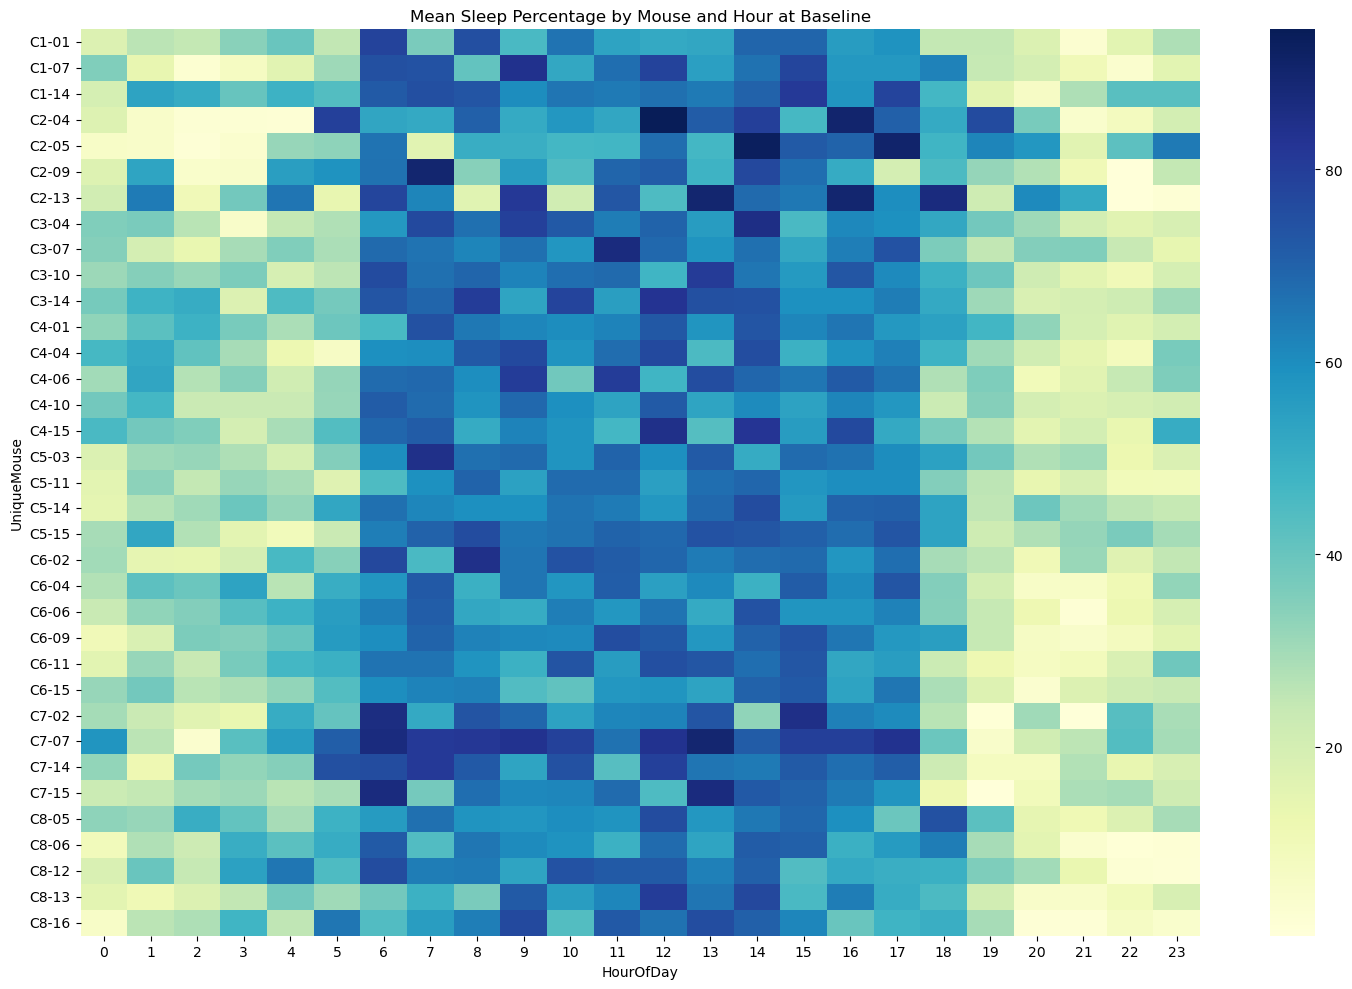

In [83]:
# Create a summary heatmap
plt.figure(figsize=(15,10))
sns.heatmap(mean_pivot, cmap="YlGnBu", annot=False)
plt.title('Mean Sleep Percentage by Mouse and Hour at Baseline')
plt.tight_layout()
plt.savefig('mean_sleep_heatmap.png')

### Postinjury Trends

6 AM - 7 AM: Transitional hour, mice are going to sleep
7 AM - 5 PM: High PercentSleep values, mice are asleep during the day
5 PM - 6 PM: Transitional hour, mice are waking up
6 PM - 11 PM: Mice are mostly awake
11 PM - 4 AM: "Middle ground" where mice sleep between 30 - 60% per hour
4 AM - 6 AM: Mice are mostly awake

Outliers:
- Following the visual trend seen on the Percent Sleep Per Hour by Cohort graphs, all mice in C7 seem to have very similar values on average, with some mild changes
- Also following the visual trend seen on Percent Sleep Per Hour by Cohort graphs, C8-16 maintains very low sleep percent values on average

### Baseline Trends
6 AM - 6 PM: Higher PercentSleep values, mice are sleeping
6 PM - 7 PM: Transitional hour, mice are waking up
7 PM - 5 AM: Lower PercentSleep values, mice are awake
5 AM - 6 AM: Transitional hour, mice are going to sleep

Outliers:
- Maybe C2-05 at 0700
- Maybe C2-13 at 0800 and 1000

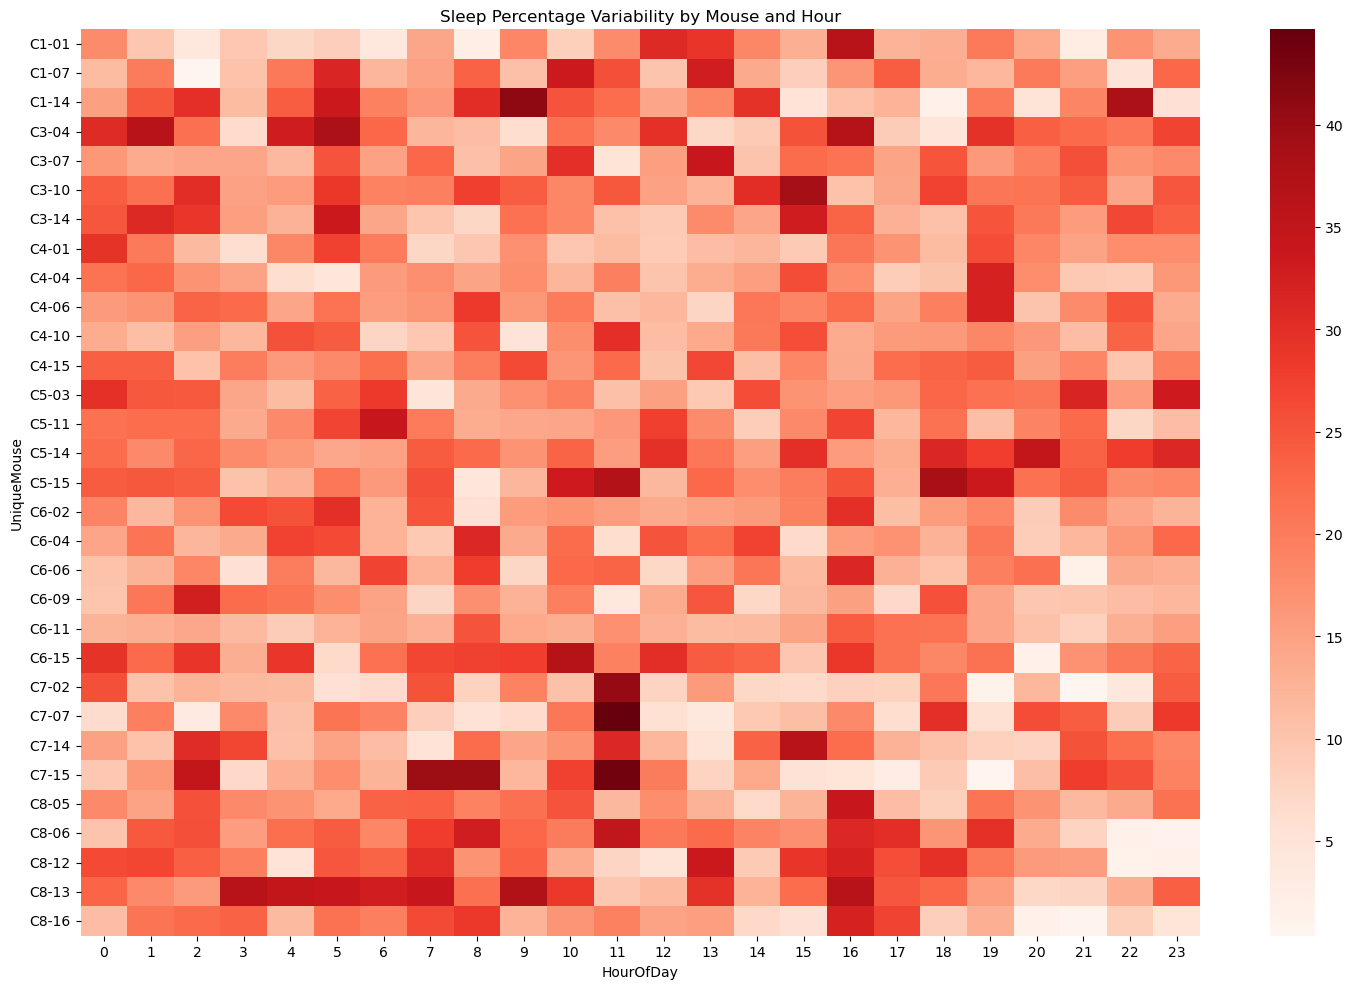

In [88]:
# Create a standard deviation heatmap to measure high variability (look for mice whose numbers change a lot)

std_pivot = pd.pivot_table(clean_df, values='PercentSleep', index='UniqueMouse', columns='HourOfDay', aggfunc='std', observed=True)

plt.figure(figsize=(15,10))
sns.heatmap(std_pivot, cmap="Reds", annot=False)
plt.title('Sleep Percentage Variability by Mouse and Hour')
plt.tight_layout()
plt.savefig('std_sleep_heatmap.png')
plt.show()

\* I am assuming that lighter colors mean less variability and darker colors mean more variability *
  
### Postinjury

#### Variability by UniqueMouse:
-Very low variability for C7-14
-Low variability for C7 in general
-High variability for C8-16

#### Variability by hour:
-Most variability at 0000, 0500, 0600, 1900

### Baseline

#### Variability by hour
- A lot of variability at 1100, specifically from animals in C7

# Normality Testing

Link: https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/

Goal: To determine whether data is normally distributed. This determines the kinds of tests you will run on it. There are analytical tests (Kolmogorov-Smirnov for small samples (n<50) or D'Agostino Pearson or Anderson-Darling for larger samples) as well as graphical tests - plotting a histogram or using a Q-Q plot. Graphical tests are a little more rigorous. 

## QQ Plot

In [ ]:
plot_hourly_mean_std(clean_df)

^ I don't think this is answering what I want it to answer